# MGO for Airy Problem

This notebook reproduces the results of Example B: **"EM Wave in unmagnetized plasma slab with linear density profile"** from [Donelly et al., 2021].

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from scipy.special import airy
import scipy

In [17]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

## Approximate Solutions

First, we plot the approximate solutions together with the exact Airy function.

In [21]:
def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

q = np.linspace(-8, -0.01, 1000)
E_ex = Ai(q) # Exact solution is Airy function
E_GO = np.pi**(-1/2) * (np.abs(q)**(-1/4)) * np.sin(2/3 * np.abs(q)**(3/2) + np.pi/4) # GO Solution

In [22]:
rho = (1-4*q) * np.sqrt(np.abs(q))
omega_bar = 2/3 * rho**3 - 2/3 * np.abs(q)**(3/2)
E_approx_MGO = np.sqrt(1-4*q) * (Ai(-rho**2) * np.cos(omega_bar) - Bi(-rho**2) * np.sin(omega_bar))

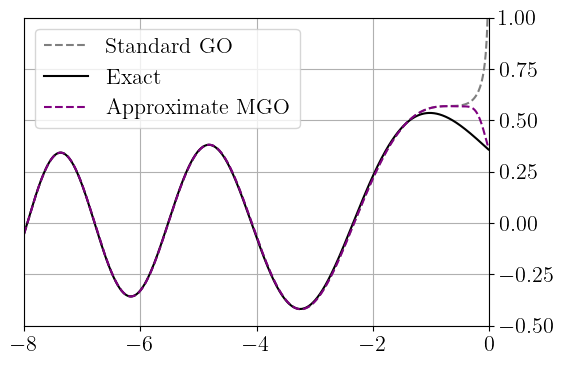

In [23]:
plt.figure(figsize=(6,4))
plt.plot(q, E_GO, '--', color='tab:grey', label='Standard GO')
plt.plot(q, E_ex, '-', color='black', label='Exact')
plt.plot(q, E_approx_MGO, '--', color='purple', label='Approximate MGO')
plt.grid()
plt.xlim(-8,0)
plt.ylim(-0.5,1)
plt.legend()
ax = plt.gca()
ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()
plt.show()

## Numerical Evaluation

We now perform the numerical evaluation of the MGO solution using Gaussian quadratures to evaluate the integral.

In [24]:
def get_nodes_and_weights(n):
    '''Returns nodes and weights from Freud polynomials for evaluating gaussian quadrature.'''
    nodes = [
        [5.64189583547756e-1],
        [3.00193931060839e-1, 1.25242104533372e-0],
        [1.90554149798192e-1, 8.48251867544577e-1, 1.79977657841573e-0],
        [1.33776446996068e-1, 6.24324690187190e-1, 1.34253782564499e-0, 2.26266447701036e-0],
        [1.00242151968216e-1, 4.82813966046201e-1, 1.06094982152572e-0, 1.77972941852026e-0, 2.66976035608766e-0],
        [7.86006594130979e-2, 3.86739410270631e-1, 8.66429471682044e-1, 1.46569804966352e-0, 2.17270779693900e-0, 3.03682016932287e-0],
        [6.37164846067008e-2, 3.18192018888619e-1, 7.24198989258373e-1, 1.23803559921509e-0, 1.83852822027095e-0, 2.53148815132768e-0, 3.37345643012458e-0],
        [5.29786439318514e-2, 2.67398372167767e-1, 6.16302884182402e-1, 1.06424631211623e-0, 1.58885586227006e-0, 2.18392115309586e-0, 2.86313388370808e-0, 3.68600716272440e-0],
        [4.49390308011934e-2, 2.28605305560535e-1, 5.32195844331646e-1, 9.27280745338081e-1, 1.39292385519588e-0, 1.91884309919743e-0, 2.50624783400574e-0, 3.17269213348124e-0, 3.97889886978978e-0],
        [3.87385243257289e-2, 1.98233304013083e-1, 4.65201111814767e-1, 8.16861885592273e-1, 1.23454132402818e-0, 1.70679814968913e-0, 2.22994008892494e-0, 2.80910374689875e-0, 3.46387241949586e-0, 4.25536180636608e-0]
    ]
    weights = [
        [8.86226925452758e-1],
        [6.40529179684379e-1, 2.45697745768379e-1],
        [4.46029770466658e-1, 3.96468266998335e-1, 4.37288879877644e-2],
        [3.25302999756919e-1, 4.21107101852062e-1, 1.33442500357520e-1, 6.37432348625728e-3],
        [2.48406152028443e-1, 3.92331066652399e-1, 2.11418193076057e-1, 3.32466603513439e-2, 8.24853344515628e-4],
        [1.96849675488598e-1, 3.49154201525395e-1, 2.57259520584421e-1, 7.60131375840058e-2, 6.85191862513596e-3, 9.84716452019267e-5],
        [1.60609965149261e-1, 3.06319808158099e-1, 2.75527141784905e-1, 1.20630193130784e-1, 2.18922863438067e-2, 1.23644672831056e-3, 1.10841575911059e-5],
        [1.34109188453360e-1, 2.68330754472640e-1, 2.75953397988422e-1, 1.57448282618790e-1, 4.48141099174625e-2, 5.36793575602526e-3, 2.02063649132407e-4, 1.19259692659532e-6],
        [1.14088970242118e-1, 2.35940791223685e-1, 2.66425473630253e-1, 1.83251679101663e-1, 7.13440493066916e-2, 1.39814184155604e-2, 1.16385272078519e-3, 3.05670214897831e-5, 1.23790511337496e-7],
        [9.85520975191087e-2, 2.08678066608185e-1, 2.52051688403761e-1, 1.98684340038387e-1, 9.71984227600620e-2, 2.70244164355446e-2, 3.80464962249537e-3, 2.28886243044656e-4, 4.34534479844469e-6, 1.24773714817825e-8]
    ]
    return np.array(nodes[n-1]), np.array(weights[n-1])

In [25]:
def integrate_gauss_freud_quad(f, n):
    '''Integrate f(x) from 0 to ∞ using Gauss Freud Quadrature of order n'''
    x_j, w_j = get_nodes_and_weights(n)
    return np.dot(w_j,  np.exp(x_j**2)*f(x_j))

In [26]:
# Define function to be integrated.
v = lambda p: np.sqrt(1+4*(p**2))
f = lambda eps, p: (
    (v(p)**6 - (v(p)**4 - 8*v(p)*p*eps)**(3/2))/(96*(p**3))
    - v(p)**3/(8*(p**2)) * eps + v(p)**2/(4*p) * eps**2
    )
df = lambda eps, p: v(p)/(8*(p**2)) * (
    4*v(p)*p*eps
    - v(p)**2
    + (v(p)**4 - 8*v(p)*p*eps)**(1/2)
    )
ddf = lambda eps, p: v(p)**2/(2*p) * (1 - (v(p)**4 - 8*v(p)*p*eps)**(-1/2)) 
g = lambda eps, p: (1/(2*np.pi)) * v(p)/(v(p)**4 - 8*v(p)*p*eps)**(1/4)

In [27]:
# sample check that values are correct
# f(4,2), g(4,2), df(4,2), ddf(4,2), g(4,2)

In [28]:
def Upsilon(p):
    eps_0 = 0

    def sigma(p):
        alpha = np.angle(ddf(eps_0, p))
        sigma_p = -np.pi/4 - alpha/2 + np.pi/2
        sigma_m = -np.pi/4 - alpha/2 - np.pi/2
        return sigma_p, sigma_m
    
    
    sigma_p, sigma_m = sigma(p)
    
    C_p = lambda l: eps_0 + np.abs(l) * np.exp(1j*sigma_p)
    C_m = lambda l: eps_0 + np.abs(l) * np.exp(1j*sigma_m)

    F_p = lambda l: np.imag(f(C_p(l), p))
    F_m = lambda l: np.imag(f(C_m(l), p))
    
    # l = np.linspace(-1,1)
    # plt.plot(l, F_m(l) - F_m(0) - 1)
    # plt.grid()
    # plt.title(p)
    Delta_F = 1
    l_p = scipy.optimize.brentq(lambda l: F_p(l) - F_p(0) - Delta_F, 0, 1000)
    l_m = scipy.optimize.brentq(lambda l: F_m(l) - F_m(0) - Delta_F, 0, 1000)
    s_p = Delta_F/(np.abs(l_p)**2)
    s_m = Delta_F/(np.abs(l_m)**2)

    h = lambda eps: g(eps, p) * np.exp(1j*f(eps, p))

    # print('s_m', s_m, 's_p', s_p, 'sigma_p', sigma_p*180/np.pi, 'sigma_m', sigma_m*180/np.pi)

    dl_p, dl_m = np.exp(1j*sigma_p)/np.sqrt(s_p), np.exp(1j*sigma_m)/np.sqrt(s_m)
    I = integrate_gauss_freud_quad(
        lambda l: (h(eps_0 + l*dl_p) * dl_p - h(eps_0 + l*dl_m) * dl_m),
        n = 10
    )

    return I

# q = np.linspace(-8, -0.1)
Ups_vec = np.vectorize(Upsilon)
E_MGO = ( Ups_vec(np.sqrt(np.abs(q))) * np.exp(-1j*(2/3)*(np.abs(q)**(3/2)))
        + Ups_vec(-np.sqrt(np.abs(q))) * np.exp(1j*(2/3)*(np.abs(q)**(3/2))) )
if np.all(np.isclose(np.imag(E_MGO), 0)):
    E_MGO = np.real(E_MGO)
else:
    print('Warning: Field has non-negligible imaginary part even though we discard the imagine part.')

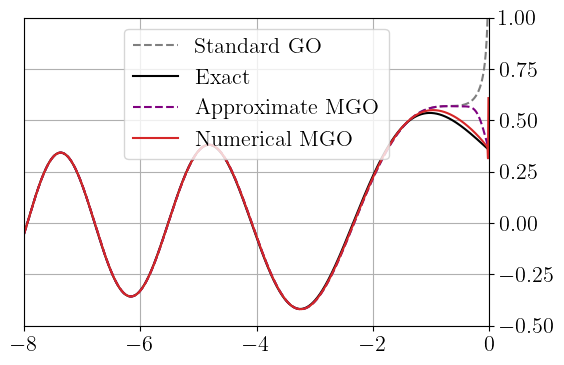

In [30]:
plt.figure(figsize=(6,4))
plt.plot(q, E_GO, '--', color='tab:grey', label='Standard GO')
plt.plot(q, E_ex, '-', color='black', label='Exact')
plt.plot(q, E_approx_MGO, '--', color='purple', label='Approximate MGO')
plt.plot(q, E_MGO, '-', color='tab:red', label='Numerical MGO')
plt.grid()
plt.xlim(-8,0)
plt.ylim(-0.5,1)
plt.legend()
ax = plt.gca()
ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()
plt.show()

### Reproduced FIG. 4

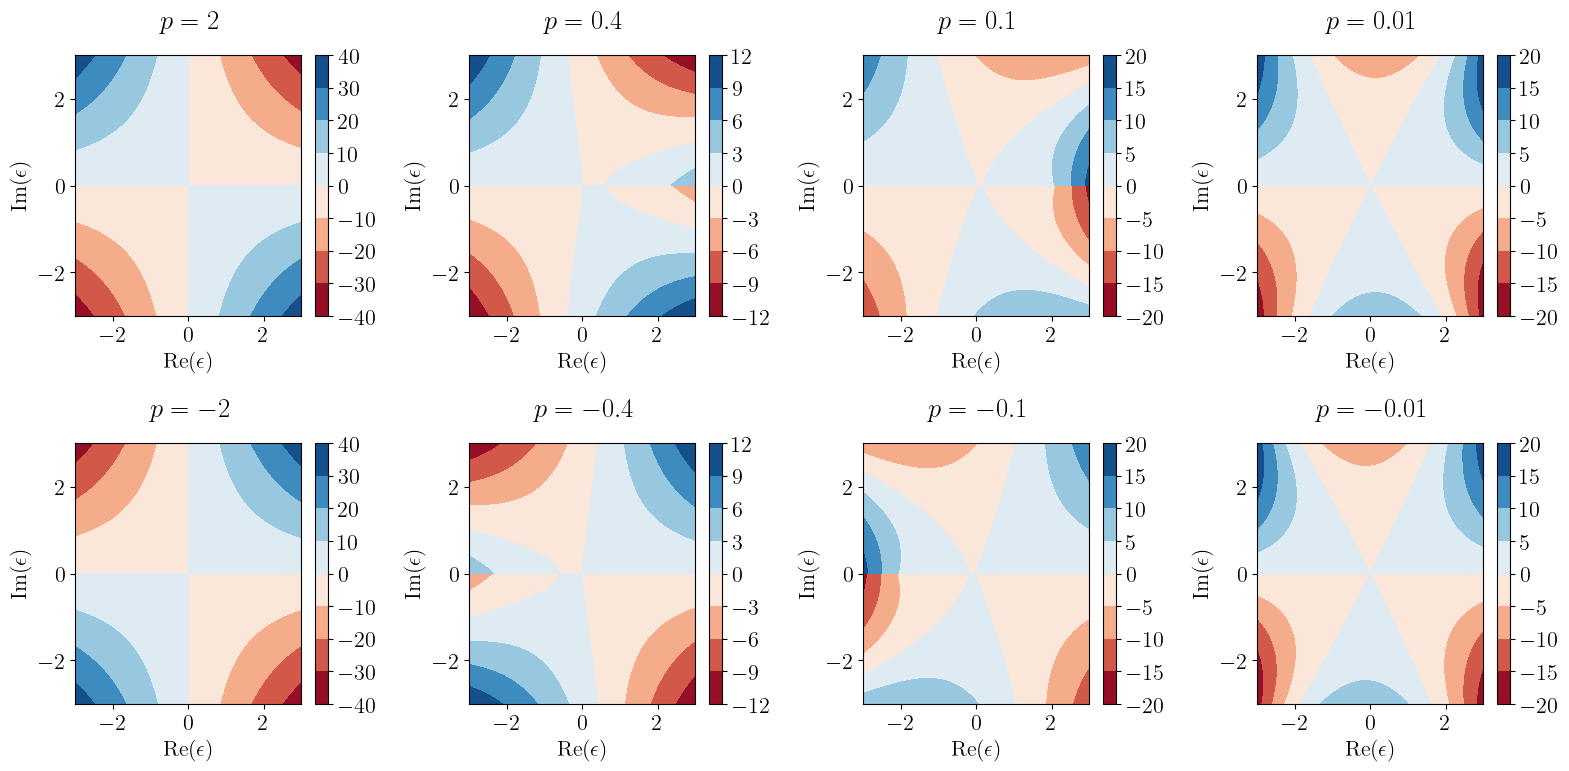

In [33]:
eps_R = np.linspace(-3,3, 1000)
eps_I = np.linspace(-3,3, 1000)
Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
Eps = Eps_R + 1j*Eps_I

p_vals = [2, 0.4, 0.1, 0.01, -2, -0.4, -0.1, -0.01]
# p_vals = [0.01, 0.05, 0.1, 0.5, 0.8, 1.0, 1.5, 2.0]
nrows, ncols = int(np.ceil(len(p_vals)/4)), 4
# fig, axes = plt.subplots(nrows, ncols, figsize=(14,8))
fig = plt.figure(figsize=(16,nrows*4))

for i, p in enumerate(p_vals):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig.add_subplot(nrows, ncols, 1 + i)
    contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f(Eps, p)), cmap='RdBu')
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title('$p = ' + str(p) + '$')
    ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')
plt.tight_layout()
plt.show()

In [23]:
# fig = plt.figure(figsize=(13,6))

# for i, p in enumerate(p_vals):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig.add_subplot(nrows, ncols, 1 + i)
#     contour_plot = ax.contourf(Eps_R, Eps_I, np.real(df(Eps, p)))
#     fig.colorbar(contour_plot, ax=ax)
#     ax.set_title('$p = ' + str(p) + '$')
#     ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
#     ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')
# plt.tight_layout()

# fig = plt.figure(figsize=(13,6))

# for i, p in enumerate(p_vals):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig.add_subplot(nrows, ncols, 1 + i)
#     contour_plot = ax.contourf(Eps_R, Eps_I, np.imag(df(Eps, p)))
#     fig.colorbar(contour_plot, ax=ax)
#     ax.set_title('$p = ' + str(p) + '$')
#     ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
#     ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')
# plt.tight_layout()